# Strategic Location For Establishing an Asian Restaurant In Seattle

## The success of a restaurant depends on many factors such as brand loyalty, income of households in a particular area, neighborhood location, quality of food and demand rate. Among all these parameters, Location undoubtedly, plays a significant role in this decision to make the restaurant business profitable and competitive in the market.

### In this project we aim to identify a strategic location for establishing an asian restaurant in Seattle. The foundation of reasoning behind this is the spending power of the household and distribution of asians living in each neighborhood. 

### 1) Importing and installing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import requests
from pandas.io.json import json_normalize

In [2]:
!conda install -c conda-forge bs4 --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |   py36h9f0ad1d_0         163 KB  conda-forge
    bs4-4.9.1                  |                0           4 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    soupsieve-2.0.1            |   py36h9f0ad1d_0          56 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         522 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/linux-64::beautifulsoup4-4.9.1-py36h9f0ad1d_0
  bs4                conda-forge/noarch::bs4-4.9.1-0
  soupsieve 

In [3]:
!conda install -c conda-forge folium --yes
print("Folium installed")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  branca             conda-forge/noarch::branca-0.4.1-py_0
  br

In [4]:
!conda install -c conda-forge geopy --yes
print("Geopy installed")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

### 2) Data Acquisition and Cleaning

##### The data which we will be needing for this capstone is not readily available. Hence we would be using web scraping techniques to extract data from various websites that will be used for further analysis in this project. Beautiful soup 4 is a python library which we would be using to scrape data from the web.

#### A) Extracting the Seattle Neighborhood data from wikipedia and storing it in pandas dataframe.

In [5]:
import urllib.request
import bs4 as bs

In [6]:
#opens the wikipedia page and passes the results to beautiful soup instance for extracting html elements and their data
sauce = urllib.request.urlopen("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle").read()
soup = bs.BeautifulSoup(sauce)
table = soup.find("table")

In [7]:
#iterates through each table row to get the neighborhood names and their respective larger district
table_rows = table.find_all("tr")
list_of_neighborhood = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [i.text for i in td]
    list_of_neighborhood.append(row)

In [8]:
#use iloc function to get rid of the first unnecessary row
neighborhood_df = pd.DataFrame(list_of_neighborhood)
neighborhood_df = neighborhood_df.iloc[1:,]

In [9]:
#drop the columns which are not required
neighborhood_df.drop([2,3,4,5,6],axis=1,inplace=True)

In [10]:
#assigning column names to the dataframe object
neighborhood_df_columns = ["NeighborhoodName","LargerDistrictName"]
neighborhood_df.columns = neighborhood_df_columns

In [11]:
#resets the index of the dataframe
neighborhood_df.reset_index(drop=False,inplace=True)

In [12]:
neighborhood_df.drop("index",axis=1,inplace=True)

In [13]:
#removes the unneccessary escape characters from the data
neighborhood_df["NeighborhoodName"] = neighborhood_df["NeighborhoodName"].str.replace("\n","")
neighborhood_df["LargerDistrictName"] = neighborhood_df["LargerDistrictName"].str.replace("\n","")

In [14]:
#display the data extracted so far
neighborhood_df.head()

,NeighborhoodName,LargerDistrictName
0,North Seattle,Seattle
1,Broadview,North Seattle[42]
2,Bitter Lake,North Seattle[42]
3,North Beach / Blue Ridge,North Seattle[42]
4,Crown Hill,North Seattle[42]


#### B) Geocoding the neighborhoods with Nominatim API to get their latitudes and longitudes

In [15]:
from geopy.geocoders import Nominatim

In [16]:
#function to validate neighborhood names to remove backslashes
def validateNeighborhoodName(name):
    values = name.split("/")
    return values[0]

In [17]:
neighborhood_df["NeighborhoodName"] = neighborhood_df["NeighborhoodName"].apply(validateNeighborhoodName)

In [18]:
#function to validate neighborhood names to remove closed brackets
def validateNeighborhoodNameForClosedBrackets(name):
    values = name.split("(")
    return values[0]

In [19]:
neighborhood_df["NeighborhoodName"] = neighborhood_df["NeighborhoodName"].apply(validateNeighborhoodNameForClosedBrackets)

In [20]:
#drop a specific row for which data is not present
neighborhood_df.drop(53,axis=0,inplace=True)

In [21]:
#reset index
neighborhood_df.reset_index(drop=False,inplace=True)

In [22]:
#geocode the data to find latitude and longitude
lat_list = []
lng_list = []
for i in range(len(neighborhood_df)):
    address = "{}, Seattle, Washington, US".format(neighborhood_df["NeighborhoodName"][i])
    geocoder = Nominatim(user_agent="ny_explorer",scheme="http")
    location = geocoder.geocode(address)
    lat_list.append(location.latitude if location != None else "Latitude Unavailable")
    lng_list.append(location.longitude if location != None else "Longitude Unavailable")

In [23]:
#to get the number of neighborhoods geocoded by Nominatim API.
no_of_records = len(lat_list)
no_of_records

126

In [24]:
#creates a new dataframe with latitude, longitude and drops the index column
neighborhood = neighborhood_df.head(no_of_records)
neighborhood["Latitude"] = lat_list
neighborhood["Longitude"] = lng_list
neighborhood.drop("index",axis=1,inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is 

In [25]:
len(neighborhood)

126

#### C) Getting each neighborhood income and number of asians in each neighborhood by web scraping. 

##### The below function iterates through each neighborhood and uses web scraping techniques to extract the population data, median household income and number of asians in each neighborhood from www.niche.com. We use the urllib.request and urllib.urlopen methods to connect to this website by passing a default user-agent in the request header. We then decode the page using the standard utf-8 style. Then this scraped source code is then passed to the Beautiful Soup 4 instance to extract the information from HTMl tags.

In [26]:
def getIncomePopulationAndAsiansByNeighborhood(neighborhoodNames):
    income_list = []
    population_list = []
    percent_asians = []
    for name in neighborhoodNames:
        dataLoaded = True
        name = name.lower()
        if(name.find(" ") != -1):
            name = name.replace(" ","-")
        url = "https://www.niche.com/places-to-live/n/"+str(name)+"-seattle-wa/residents"
        print(url)
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'})
        try:
            web_byte = urlopen(req).read()
        except:
            print("Data not available")
            dataLoaded = False
        if(dataLoaded == True):
            webpage = web_byte.decode('utf-8')
            soup = bs.BeautifulSoup(webpage)
        
            #getting the total population
            residents_sec = soup.find("section", attrs={'id':'about-residents'})
            total_population = residents_sec.find("div", attrs={'class':'scalar__value'}).find("span")
            population_list.append(total_population.text.replace(",",""))
        
            #getting the median household income of each neighborhood
            income_sec = soup.find("section", attrs={'id':'income'})
            median_household_income = income_sec.find("div", attrs={'class':'scalar__value'}).find("span")
            income_list.append(median_household_income.text.replace(",","").replace("$",""))
        
            #getting the number of asians
            demographics_sec = soup.find("section", attrs={'id':'demographics'})
            racial_values = demographics_sec.findChildren("ul", attrs={'class':'breakdown-facts'})[1]
            list_values = racial_values.find_all("li")
            temp = []
            for li in list_values:
                temp.append([i.text for i in li])
            percent_asians.append(temp[2][2].replace("%",""))
        else:
            population_list.append("Not Available")
            income_list.append("Not Available")
            percent_asians.append("Not Available")
        
    return population_list,income_list,percent_asians

In [27]:
# Calling the above function passing the NeighborhoodName pandas Series object
#population_list,income_list,percent_asians = getIncomePopulationAndAsiansByNeighborhood(neighborhood["NeighborhoodName"])

##### Since Web scraping techinques entails some shortcommings such as the website might change the source code dynamically and generalizing the scraper across multiple websites is challenging. Also most of the websites implement stringent security standards to prevent the page from being accessible from scripts. Furthermore the urllib.urlopen throws a 403 forbidden error or a timed out exception in case the url is not accessible from the above python script.

##### As a result, to reduce dependency on webscraping, the above code has been run and the resulting values had been saved to a csv file. For furthur analysis in the project we would be importing the csv file using pandas and continuing with next steps.

In [28]:
neighborhood = pd.read_csv("Neighborhood.csv")

In [29]:
#Checking the dataset using the pandas head method. By default only 5 rows are displayed. We can pass n as a parameter
# denoting the number of rows to display.
neighborhood.head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent
0,0,North Seattle,Seattle,47.6607729,-122.2914971,NaN,NaN,NaN
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.0,116281.0,8.0
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.0,65626.0,12.0
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.0,25000.0,8.0
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.0,118587.0,5.0


In [30]:
# the describe method gives the descriptive statistics for each of the numerical columns.
neighborhood.describe()

,Unnamed: 0,Population,HouseholdIncome,AsiansPercent
count,126.000000,118.000000,118.000000,118.000000
mean,62.500000,9032.652542,95167.245763,10.796610
std,36.517119,9462.762461,38838.937100,4.556501
min,0.000000,379.000000,2121.000000,2.000000
25%,31.250000,4463.000000,71257.250000,8.000000
50%,62.500000,7957.000000,102103.500000,10.000000
75%,93.750000,9473.250000,115798.500000,13.000000
max,125.000000,78545.000000,198969.000000,29.000000


In [31]:
# The info function displays the dtype used for each fetaure in our dataset.
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          126 non-null    int64  
 1   NeighborhoodName    126 non-null    object 
 2   LargerDistrictName  126 non-null    object 
 3   Latitude            126 non-null    object 
 4   Longitude           126 non-null    object 
 5   Population          118 non-null    float64
 6   HouseholdIncome     118 non-null    float64
 7   AsiansPercent       118 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.0+ KB


#### D) Handling the missing values

##### The dataset contains missing values which can act as an impedement for further analysis if not handled ore removed completely. There are many ways of dealing with missing values in our analysis. Firstly, we can drop the rows containing missing values, or we can replace the missing values with the the representative values (the average or median values for each columns)

##### In this project we will be replacing the missing values with the average/median value for that particular column.

In [32]:
#replacing with mean value
neighborhood["Population"] = neighborhood["Population"].replace(np.nan, neighborhood["Population"].mean())

In [33]:
#replacing with mean value
neighborhood["HouseholdIncome"] = neighborhood["HouseholdIncome"].replace(np.nan, neighborhood["HouseholdIncome"].mean())

In [34]:
#replacing with mean value
neighborhood["AsiansPercent"] = neighborhood["AsiansPercent"].replace(np.nan, neighborhood["AsiansPercent"].median())

In [35]:
neighborhood.head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent
0,0,North Seattle,Seattle,47.6607729,-122.2914971,9032.652542,95167.245763,10.0
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.000000,116281.000000,8.0
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.000000,65626.000000,12.0
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.000000,25000.000000,8.0
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.000000,118587.000000,5.0


In [36]:
# this denotes the end of data acquisition and cleaning phase

### 3) Exploratory Data Analysis

##### Exploratory data analysis is the preliminary step in data analysis. It is used to summarize the main characteristics of data, gain better understanding of data set and to unleash the various relationships in the underlying data. It can also be used to determine features that have a significant impact on the machine learning algorithm in which the predictive model will be deployed.

#### A) Visualizing the Seattle Neighborhoods on a Folium Leaflet map.

In [37]:
#Using geocoding to get seattles location coordinates.
address = "Seattle, Washington, US"
geocoder = Nominatim(user_agent="ny_explorer",scheme="http")
location = geocoder.geocode(address)
seattle_latitude = location.latitude
seattle_longitude = location.longitude
"The location co-ordinates of Seattle are {} and {}".format(seattle_latitude,seattle_longitude)

'The location co-ordinates of Seattle are 47.6038321 and -122.3300624'

In [38]:
import folium

In [39]:
seattle_map = folium.Map(location=[seattle_latitude,seattle_longitude],zoom_start=12)
seattle_map

In [40]:
for lat,lng,name, category in zip(neighborhood["Latitude"],neighborhood["Longitude"],  \
                                  neighborhood["NeighborhoodName"],neighborhood["LargerDistrictName"]):
    if(lat != "Latitude Unavailable" and lng != "Longitude Unavailable"):
        label = folium.Popup(str(name)+", "+str(category))
        folium.CircleMarker(
        location = [lat,lng],
        popup =label,
        radius=5,
        fill = True,
        fill_color = "red",
        fill_opacity = 0.7
        ).add_to(seattle_map)
    
#Display the seattle map
seattle_map
    

#### B) Visualizing using Bar graphs

In [41]:
import matplotlib.pyplot as plt

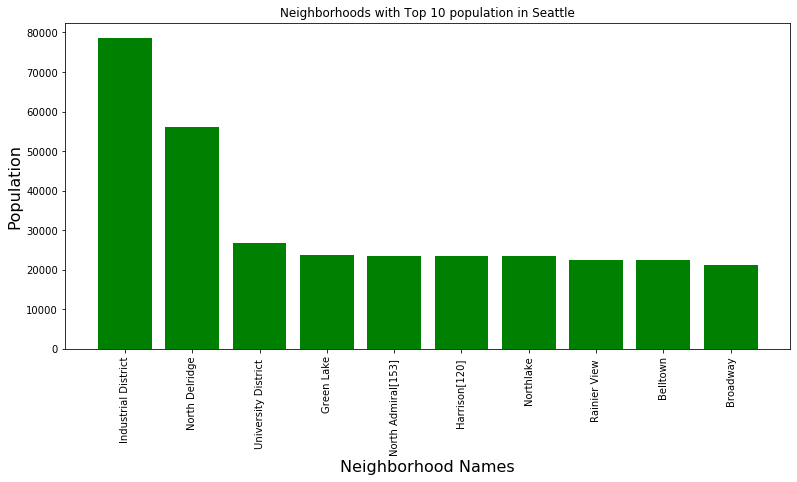

In [42]:
#the below code slices the original dataframe, sorts it in descending order to draw a bar graph to show the
#top 10 populous neighborhoods in seattle.
df_population = neighborhood.loc[:,["NeighborhoodName","Population"]]
df_population = df_population.sort_values(by="Population",ascending=False)
df_population = df_population.head(10)
index = np.arange(len(df_population["NeighborhoodName"]))
plt.figure(figsize=(13,6))
plt.bar(index,df_population["Population"],color="green")
plt.xticks(index,df_population["NeighborhoodName"],rotation=90)
plt.xlabel("Neighborhood Names",fontsize=16)
plt.ylabel("Population",fontsize=16)
plt.title("Neighborhoods with Top 10 population in Seattle")
plt.show()

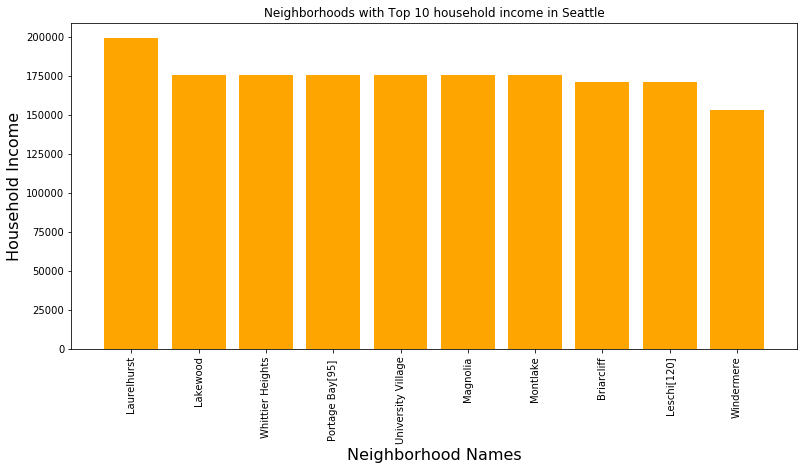

In [43]:
#the below code slices the original dataframe, sorts it in descending order of their incomes to draw a bar graph to show the
#top 10 neighborhoods in seattle.
df_income = neighborhood.loc[:,["NeighborhoodName","HouseholdIncome"]]
df_income = df_income.sort_values(by="HouseholdIncome",ascending=False)
df_income = df_income.head(10)
index = np.arange(len(df_income["NeighborhoodName"]))
plt.figure(figsize=(13,6))
plt.bar(index,df_income["HouseholdIncome"],color="orange")
plt.xticks(index,df_income["NeighborhoodName"],rotation=90)
plt.xlabel("Neighborhood Names",fontsize=16)
plt.ylabel("Household Income",fontsize=16)
plt.title("Neighborhoods with Top 10 household income in Seattle")
plt.show()

### 4) Using the Foursquare API to find number of Asian Restaurants

In [44]:
# defining the foursquare api keys
CLIENT_ID = 'QVWGG5LGOZVOBV5YZBX2ZKR5ACBGHVIM5OVHJKAHGLPEPTV1' # your Foursquare ID
CLIENT_SECRET = '3U14W2WYWO0T3D1NETWMPOC3CPTBHZJRLFS14BM1JWP5XW4Y'
VERSION = '20180605' # Foursquare API version
RADIUS = 500
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QVWGG5LGOZVOBV5YZBX2ZKR5ACBGHVIM5OVHJKAHGLPEPTV1
CLIENT_SECRET:3U14W2WYWO0T3D1NETWMPOC3CPTBHZJRLFS14BM1JWP5XW4Y


##### We will be using the FoursquareAPI to find the number of asian restaurants in each neighborhood. The Foursquare API  gives the /venues/explore endpoint to fetch such venues. The inputs to this API are the client id, client secret, version and categoryId. There are specific values for categoryId for each type of category we wish to explore. A detailed list of such categories can be found on the Foursquare Venue categories page.

##### For the purpose of theis project we would be using categoryId = 4bf58dd8d48988d142941735 that represents Asian Restaurants

In [45]:
CATEGORY_ID = "4bf58dd8d48988d142941735"

##### The below function loops through each neighborhood and uses the FOURSQUARE API to determine the number of asian restaurants in each neighborhood. Knowing the knowledge of competitors can better equip the decision making model to decide where to establish the restaurant business

In [46]:
def getNumberOfAsianRestaurantsByNeighborhood(neighborhood_names, latitudes, longitudes):
    no_of_rest =[]
    for name,lat,lng in zip(neighborhood_names,latitudes,longitudes):
        if(lat != "Latitude Unavailable" and lng != "Longitude Unavailable"):
            url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            RADIUS,
            LIMIT,
            CATEGORY_ID
            )
            results = requests.get(url).json()
            no_of_rest.append(len(results["response"]["groups"][0]["items"]))
        else:
            no_of_rest.append(0)
    return no_of_rest

In [47]:
#calls the above function to get the number of restaurant count for each neighborhood.
no_of_rest = getNumberOfAsianRestaurantsByNeighborhood(neighborhood["NeighborhoodName"],neighborhood["Latitude"],neighborhood["Longitude"])

In [48]:
#adding this column in our original dataframe
neighborhood["NumberOfAsianRestaurants"] = no_of_rest

In [49]:
#show the first 5 rows of the new dataset.
neighborhood.head(5)

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants
0,0,North Seattle,Seattle,47.6607729,-122.2914971,9032.652542,95167.245763,10.0,3
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.000000,116281.000000,8.0,2
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.000000,65626.000000,12.0,15
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.000000,25000.000000,8.0,0
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.000000,118587.000000,5.0,0


### 5) Data Pre-processing

#### A) Calculating the number of Asians in each Neighborhood. Dimensionality Reduction.

##### The number of asians in each neighborhood can be found by calculating the percentage and adding it as a separate columns 

In [50]:
neighborhood["AsianPopulation"] = (neighborhood["Population"]*neighborhood["AsiansPercent"])/100

In [51]:
neighborhood.head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation
0,0,North Seattle,Seattle,47.6607729,-122.2914971,9032.652542,95167.245763,10.0,3,903.265254
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.000000,116281.000000,8.0,2,642.000000
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.000000,65626.000000,12.0,15,960.360000
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.000000,25000.000000,8.0,0,268.960000
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.000000,118587.000000,5.0,0,222.100000


#### B) Feature Scaling/ Data Normalization

##### The different features in our dataset belong to different ranges. These differences in ranges can pose a serious threat to our analysis since there is a possibility that one feature might dominate our analysis than the rest. To overcome these problems, Standardization techniques are used to scale the features so that they all fall within a same range. As a result, all the features contribute equally to our predictive analysis.

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
# create the required dataset of features that will be used for modelling.
model_dataset = neighborhood[["HouseholdIncome","NumberOfAsianRestaurants","AsianPopulation"]]
model_dataset.head()

,HouseholdIncome,NumberOfAsianRestaurants,AsianPopulation
0,95167.245763,3,903.265254
1,116281.000000,2,642.000000
2,65626.000000,15,960.360000
3,25000.000000,0,268.960000
4,118587.000000,0,222.100000


In [54]:
#using StandardScaler
scaler = StandardScaler()
model_dataset = scaler.fit_transform(model_dataset)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
model_dataset = pd.DataFrame(model_dataset)

In [56]:
model_dataset.head()

,0,1,2
0,0.000000,-0.245445,-0.075925
1,0.564145,-0.313715,-0.284396
2,-0.789321,0.573790,-0.030367
3,-1.874819,-0.450254,-0.582056
4,0.625759,-0.450254,-0.619447


##### Now our dataset is within the same range and proper to train the clustering model.

### 6) Predictive Modelling

#### Predictive modelling entails the use of machine learning algorithms to analyze the given dataset and anticipate the outcomes for new data. In this project, we would be using the unsupervised machine learning algorithms to divide the neighborhoods in seattle in a cluster such that the neighborhoods having similarity are placed in same cluster. This technique aims to create clusters such that all the members in a cluster have less intracluster distances and more intercluster distances.

#### A) Calculating the Hyperparameter K

##### We will be implementing the K Means clustering algorithm for this purpose. This algorithm divides the data into non overlapping subsets. It tries to minimize the Within Cluster Sum of Squares(WCSS) error. It needs the selection of a hyperparameter K that determines the number of clusters to form. We would be implementing the ELBOW method to determine the optimum number of clusters that would be required for this analysis.

##### In the elbow method, we would be calculating the WCSS taking different number of K for each iteration and selecting the K on the basis of the plot drawn in the code below.

In [57]:
from sklearn.cluster import KMeans

In [76]:
wcss = []
for k in range(3,10):
    kmeans = KMeans(init="k-means++",n_clusters = k)
    kmeans.fit(model_dataset)
    wcss.append(kmeans.inertia_)

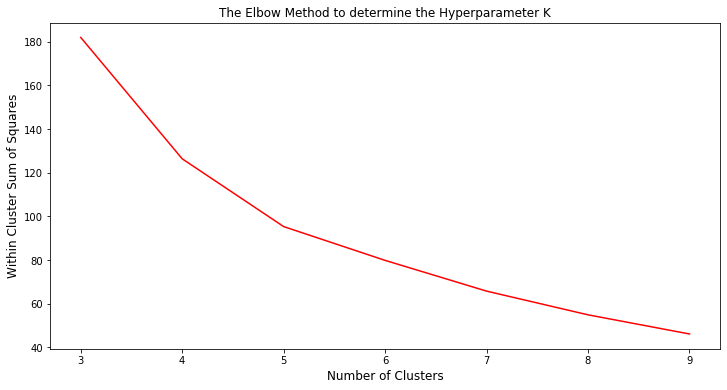

In [77]:
#plot the wcss versus the number of clusters.
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(3,10),wcss, color="red")
plt.xlabel("Number of Clusters",fontsize=12)
plt.ylabel("Within Cluster Sum of Squares", fontsize=12)
plt.title("The Elbow Method to determine the Hyperparameter K")
plt.show()

##### From the above graph we determine the number of cluster to be used as 6. K=6

#### B) K Means Clustering

In [60]:
kmeans = KMeans(n_init = 12, n_clusters=6,init="k-means++")
kmeans.fit(model_dataset)
labels = kmeans.labels_
wcss = kmeans.inertia_

In [61]:
"The Within cluster sum of squares is {}".format(wcss)

'The Within cluster sum of squares is 77.94929850332502'

In [62]:
"The cluster labels are {}".format(labels)

'The cluster labels are [0 0 1 1 0 0 1 1 3 0 1 1 1 0 0 1 1 1 0 1 0 0 0 5 1 5 2 5 0 0 0 0 0 1 0 5 0\n 0 0 0 5 0 5 0 0 0 0 0 0 0 0 5 3 5 0 0 0 1 0 0 0 5 0 3 0 3 0 4 1 3 1 3 0 3\n 1 1 0 3 1 0 0 0 0 1 0 0 5 0 0 1 0 0 0 0 0 4 0 5 0 1 1 1 1 4 1 0 0 0 0 1 0\n 0 0 0 0 1 1 0 0 4 1 1 0 0 0 0]'

In [63]:
#add the generated clusters to the original dataframe
neighborhood["ClusterNumber"] = labels

In [64]:
#check the original dataframe
neighborhood.head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
0,0,North Seattle,Seattle,47.6607729,-122.2914971,9032.652542,95167.245763,10.0,3,903.265254,0
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.000000,116281.000000,8.0,2,642.000000,0
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.000000,65626.000000,12.0,15,960.360000,1
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.000000,25000.000000,8.0,0,268.960000,1
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.000000,118587.000000,5.0,0,222.100000,0


### C) Visualizing the Resulting Clusters on Folium Map.

In [65]:
seattle_clusters = folium.Map(location=[seattle_latitude,seattle_longitude],zoom_start=11)

In [66]:
#initialize clusters for visualization
from matplotlib import cm
from matplotlib import  colors
x = np.arange(6)
ys = [i + x + (i * x) ** 2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [67]:
#display the clusters on the map
for lat, lng, name, cluster in zip(neighborhood["Latitude"],neighborhood["Longitude"],neighborhood["NeighborhoodName"],  \
                                  neighborhood["ClusterNumber"]):
    if(lat != "Latitude Unavailable" and lng != "Longitude Unavailable"):
        label = folium.Popup(str(name)+ ", Cluster - "+ str(cluster))
        folium.CircleMarker(
        location=[lat,lng],
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7
        ).add_to(seattle_clusters)

In [68]:
seattle_clusters

### 7) Clusters Summary

##### Here we will summarize the clusters formed by kmeans to decide which would be a desirable neighborhood in Seattle to establish an Asian restaurant.

#### CLuster 0
#####      MEDIUM Spending Power
#####      MEDIUM Number of target customers
#####      LOW Number of competitors

In [69]:
neighborhood[neighborhood["ClusterNumber"] == 0].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
0,0,North Seattle,Seattle,47.6607729,-122.2914971,9032.652542,95167.245763,10.0,3,903.265254,0
1,1,Broadview,North Seattle[42],47.7223199,-122.3604067,8025.000000,116281.000000,8.0,2,642.000000,0
4,4,Crown Hill,North Seattle[42],47.6947154,-122.3714586,4442.000000,118587.000000,5.0,0,222.100000,0
5,5,Greenwood,North Seattle[42],47.6909806,-122.3548773,16222.000000,93810.000000,8.0,7,1297.760000,0
9,9,North College Park,Northgate[50],Latitude Unavailable,Longitude Unavailable,2222.000000,88620.000000,11.0,0,244.420000,0


#### CLuster 1
#####      HIGH Spending Power
#####      LOW Number of target customers
#####      LOW Number of competitors

In [70]:
neighborhood[neighborhood["ClusterNumber"] == 1].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
2,2,Bitter Lake,North Seattle[42],47.7262358,-122.3487639,8003.0,65626.0,12.0,15,960.36,1
3,3,North Beach,North Seattle[42],47.6962103,-122.392362,3362.0,25000.0,8.0,0,268.96,1
6,6,Northgate,North Seattle[42],47.7131534,-122.3212307,2322.0,60000.0,10.0,0,232.20,1
7,7,Haller Lake,Northgate[50],47.7197478,-122.3337513,8203.0,72428.0,17.0,0,1394.51,1
10,10,Maple Leaf,Northgate[50],47.6939869,-122.322905,8888.0,64484.0,14.0,1,1244.32,1


#### CLuster 2
#####      MEDIUM Spending Power
#####      MEDIUM Number of target customers
#####      HIGH Number of competitors

In [71]:
neighborhood[neighborhood["ClusterNumber"] == 2].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
26,26,University District,North Seattle[42],47.6612984,-122.3131523,26699.0,56697.0,29.0,72,7742.71,2


#### CLuster 3
#####      LOW Spending Power
#####      HIGH Number of target customers
#####      LOW Number of competitors

In [72]:
neighborhood[neighborhood["ClusterNumber"] == 3].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
8,8,Pinehurst,Northgate[50],47.6038321,-122.3300624,7845.000000,63283.000000,14.0,44,1098.300000,3
52,52,Broadway,Capitol Hill[94],47.6151397,-122.3208268,21183.000000,81434.000000,5.0,41,1059.150000,3
63,63,Westlake,Lake Union,47.61181745,-122.3361891,1864.000000,105551.000000,11.0,62,205.040000,3
65,65,Downtown,Central Seattle,47.6048723,-122.3334582,2646.000000,84156.000000,9.0,48,238.140000,3
69,69,Central Business District,Downtown[107],47.6095317,-122.3362895,9032.652542,95167.245763,10.0,61,903.265254,3


#### CLuster 4
#####      HIGH Spending Power
#####      MEDIUM Number of target customers
#####      LOW Number of competitors

In [73]:
neighborhood[neighborhood["ClusterNumber"] == 4].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
67,67,Belltown,Downtown[107],47.6132311,-122.3453607,22354.0,8985.0,17.0,32,3800.18,4
95,95,Rainier View,Rainier Valley[129],Latitude Unavailable,Longitude Unavailable,22354.0,8985.0,17.0,0,3800.18,4
103,103,Industrial District,South End,Latitude Unavailable,Longitude Unavailable,78545.0,2121.0,12.0,0,9425.40,4
119,119,North Delridge,Delridge[162],47.5521233,-122.3638741,56001.0,89565.0,11.0,1,6160.11,4


#### CLuster 5
#####      MEDIUM Spending Power
#####      MEDIUM Number of target customers
#####      HIGH Number of competitors

In [74]:
neighborhood[neighborhood["ClusterNumber"] == 5].head()

,Unnamed: 0,NeighborhoodName,LargerDistrictName,Latitude,Longitude,Population,HouseholdIncome,AsiansPercent,NumberOfAsianRestaurants,AsianPopulation,ClusterNumber
23,23,Windermere,North Seattle[42],47.6709318,-122.2617917,4627.0,153080.0,12.0,0,555.24,5
25,25,Laurelhurst,North Seattle[42],47.6634317,-122.2770698,4558.0,198969.0,10.0,0,455.80,5
27,27,University Village,Ravenna[42] / University District,47.6627401,-122.2989251,4463.0,175570.0,10.0,5,446.30,5
35,35,Whittier Heights,Ballard[78],47.683297,-122.3714487,4463.0,175570.0,10.0,1,446.30,5
40,40,Magnolia,Central Seattle[42],47.6468106,-122.399489,4463.0,175570.0,10.0,1,446.30,5
